## Imports

In [5]:
import pandas as pd
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import Precision
from torchmetrics import Recall
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.modules.loss import BCEWithLogitsLoss
import torch.nn as nn
from tqdm import tqdm
import warnings
import time
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import pandas as pd
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import LambdaLR
import cv2
from torch.cuda import amp
from torch.nn import functional as F
import random
from utils.util import get_model, Args, create_loss_fn, evaluate

## Train

In [ ]:
from utils.util import get_model, Args, create_loss_fn, evaluate
import torchvision.transforms.functional as F

def train(model, dataloader, optimizer, criterion, epoch, device="cuda"):
    
    model.train()
    epoch_loss = 0

    for i, data in tqdm(enumerate(dataloader), total = len(dataloader)):

        optimizer.zero_grad() # Clear gradients.
        x_batch , y_batch = data
        x_batch = x_batch.to(device) #move to gpu
        #y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu

        #make prediction
        logits = model(x_batch)
        #compute loss

        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss/len(dataloader)
    
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

traindir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/training"
testdir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/validation"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    #transforms.RandAugment(),
                                    transforms.ToTensor(),                              
                                    torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])
                            

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_model("resnet", 18, 2)
model = model.to(device)

args = Args()

#binary cross entropy with sigmoid, so no need to use sigmoid in the model
loss_fn = create_loss_fn(args) 
#optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3, weight_decay = 5e-4, momentum = 0.9) 
#lr scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 75])

epoch_val_losses = []
epoch_val_acc = [] 

n_epochs = 100

for epoch in range(n_epochs):

  #training
  train(model, trainloader, optimizer, loss_fn, epoch)  
  scheduler.step()

  #validation
  val_loss, acc = evaluate(args, testloader, model, loss_fn)
  epoch_val_losses.append(val_loss)
  epoch_val_acc.append(acc)
  print('Epoch : {}, val loss : {}'.format(epoch+1, val_loss), end='\r')  
  
  best_loss = min(epoch_val_losses)
  best_acc =  max(epoch_val_acc)
  print(acc, best_acc, acc.item() >= best_acc)
  #save best model
  if acc.item() >= best_acc.item():
    print("saving", end='\r')
    torch.save(model.state_dict(), 'C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/resnet.pth')

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model("resnet", 18, 2)
model = model.to(device)
model.load_state_dict(torch.load('C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/resnet.pth'))

<All keys matched successfully>

## Evaluation

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model("resnet", 18, 2)
model = model.to(device)
model.load_state_dict(torch.load('C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/resnet.pth'))

args = Args()
testdir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/validation"

#transformations
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

test_data = datasets.ImageFolder(testdir,transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)
loss_fn = create_loss_fn(args) 
evaluate(args, testloader, model, loss_fn)

Test Iter:  16/ 16. Data: 0.12s. Batch: 0.21s. Loss: 0.1035. acc: 98.03: 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


(0.1035291670022283, tensor(98.0315))

In [14]:
def performance(model, dataloader, title):

    p = Precision(task = "multiclass", average= None, num_classes= 2)
    r = Recall(task = "multiclass", average= None, num_classes= 2)

    with torch.no_grad():

        target = []
        output = []

        for x_batch, y_batch in dataloader:
            target.append(y_batch)
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()

            yhat = model(x_batch).argmax(-1).cpu()
            output.append(yhat)

    tar = torch.hstack(target).squeeze()
    out = (torch.hstack(output).T).squeeze().cpu()

    metric = BinaryAccuracy(threshold = 0.5)
    print(f"Accuracy: {metric(out, tar)}")

    #bynarization
    t = 0.50  # threshold
    o = (out > t).int() * 1

    print(f"\nPrecision Damage: {p(o, tar)[0]} \nPrecision No Damage: {p(o, tar)[1]}")
    print(f"\nRecall Damage: {r(o, tar)[0]} \nRecall No Damage: {r(o, tar)[1]}")

    cm = confusion_matrix(tar, o)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['damage', "no_damage"])
    disp.plot()
    plt.title(title)
    plt.show()

C:\Users\UTENTE\AppData\Local\Temp\ipykernel_6884\1977126827.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  out = (torch.hstack(output).T).squeeze().cpu()


Accuracy: 0.9803149700164795

Precision Damage: 1.0 
Precision No Damage: 0.9615384340286255

Recall Damage: 0.961240291595459 
Recall No Damage: 1.0


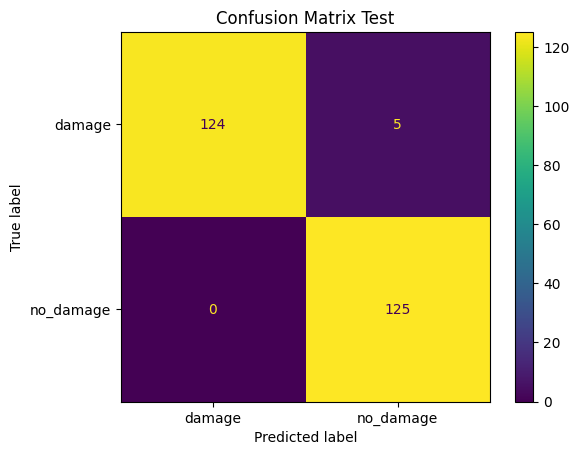

In [15]:
performance(model, testloader, "Confusion Matrix Test")

## Detection

(-0.5, 447.5, 223.5, -0.5)

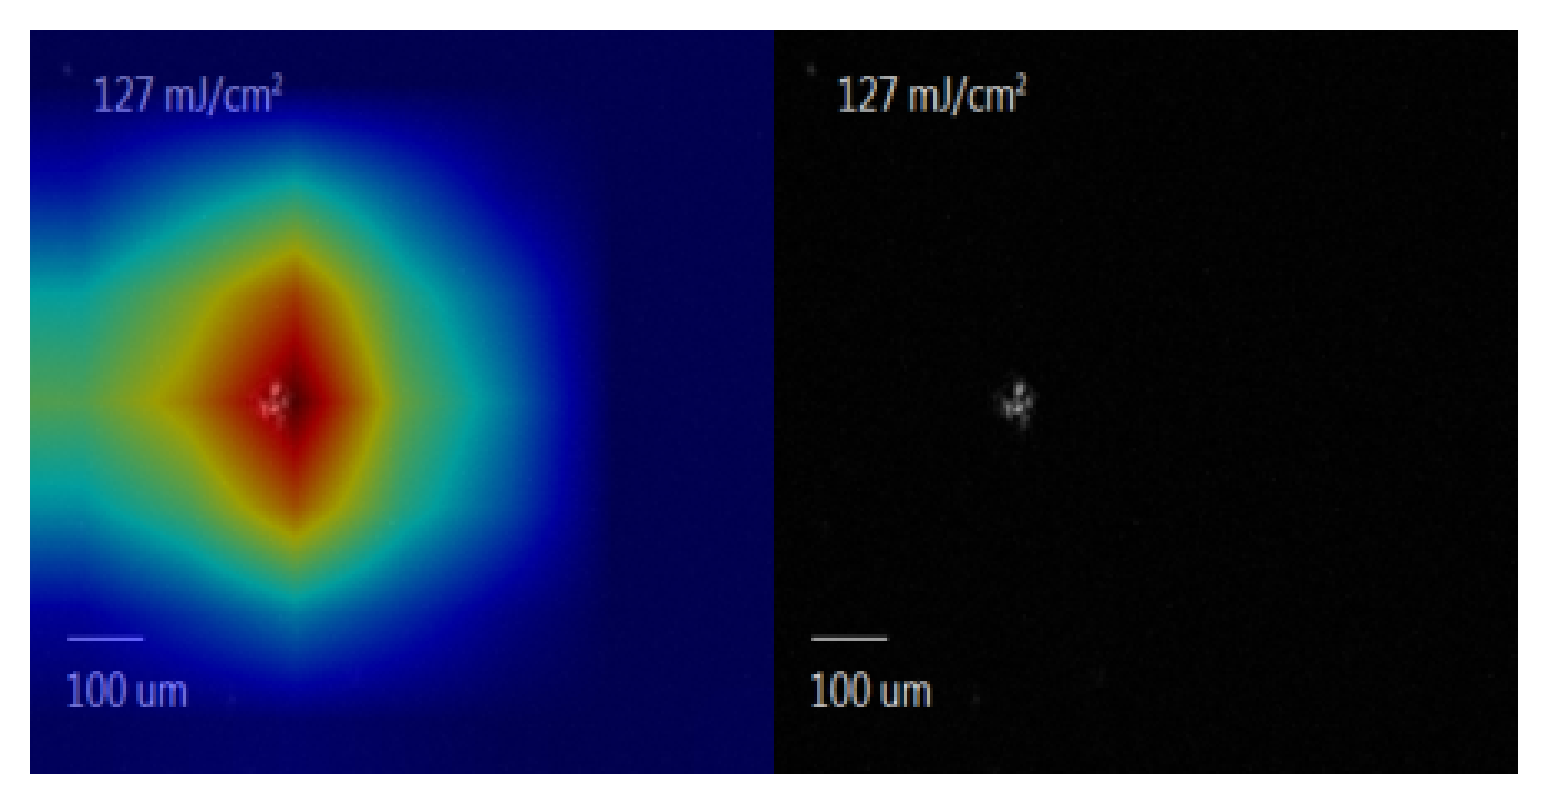

In [25]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from fastai.vision.all import *

from utils.util import *


#model = resnet50(pretrained=True)
model = model.eval().cuda()
target_layers = [model.layer4[-1]]

traindir = "C:/Users/UTENTE/Desktop/Desktop/ELI_DemageDetection/data/new_data/training"

idx = torch.randint(1, len(os.listdir(traindir + "/damage")), (1,))
image = Image.open(traindir + "/damage" + "/" + os.listdir(traindir + "/damage")[idx])
res = torchvision.transforms.Compose([
    transforms.Resize((224,224)),])
image = res(image)
image_float_np = np.float32(image) / 255


# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
input_tensor = input_tensor.unsqueeze(0)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)


grayscale_cam = cam(input_tensor=input_tensor, targets=None)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# Find the index of the maximum value
max_index = np.argmax(grayscale_cam)

plt.rcParams['figure.dpi'] = 300
plt.imshow(np.hstack((np.array(visualization),np.array(image))))
plt.axis("off")


(1, 224, 224)
Bounding box coordinates: [50, 74, 99, 146]


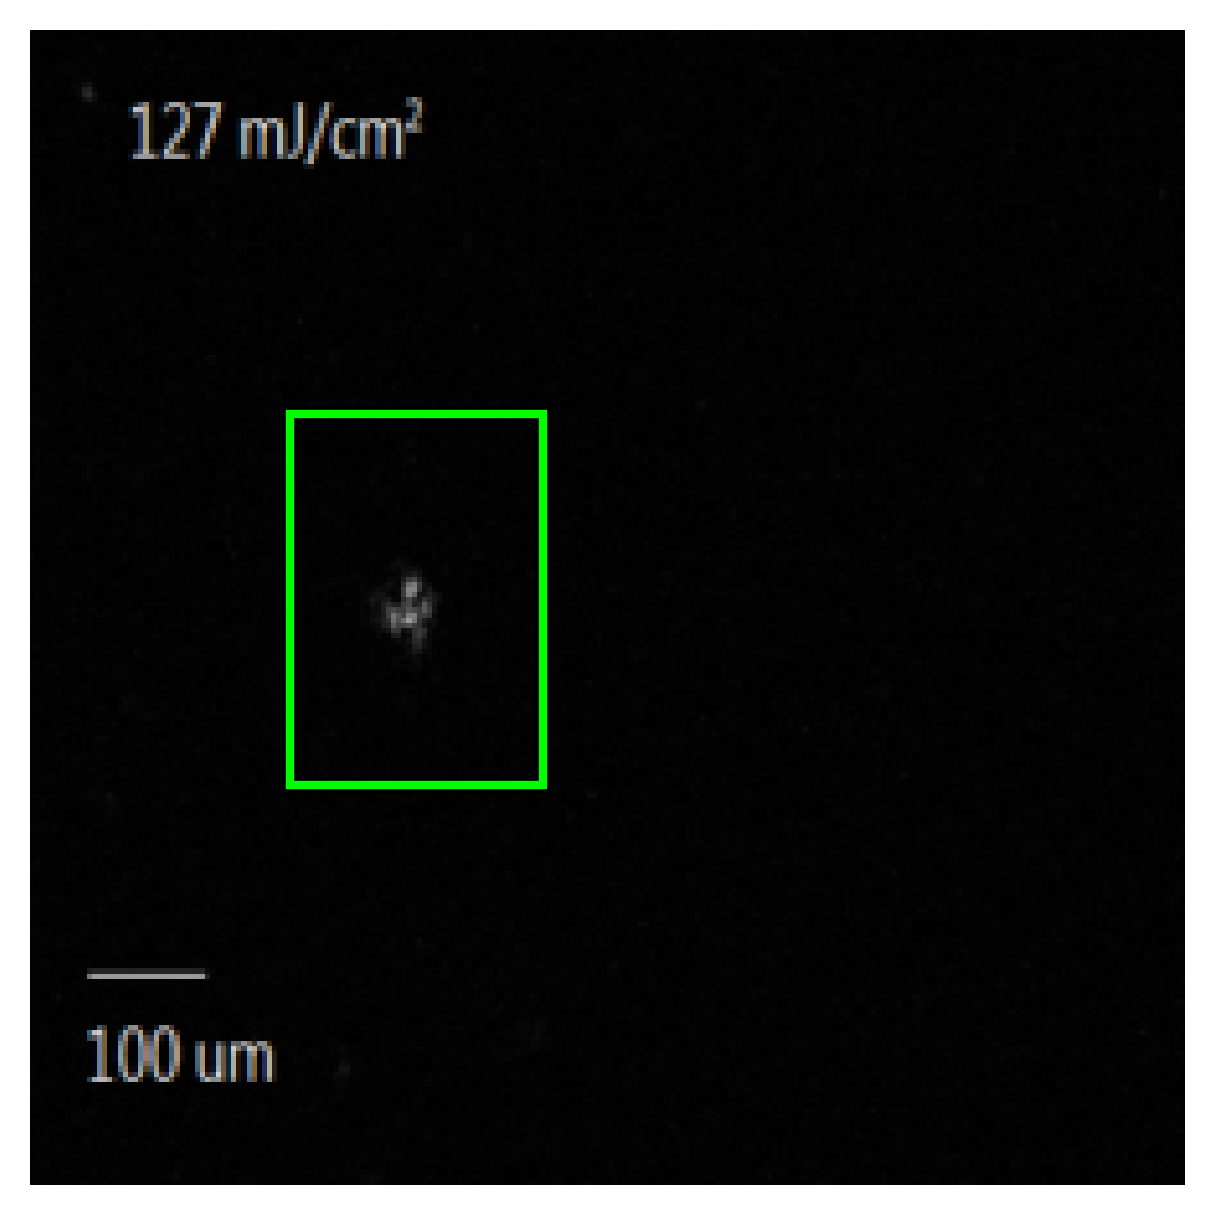

In [26]:
import numpy as np
from scipy import ndimage



# Assuming you have the class activation maps (CAMs) for an image
# stored in a numpy array called `class_activation_maps`
# Shape of class_activation_maps: (num_classes, height, width)
grayscale= np.expand_dims(grayscale_cam, 0)
print(np.shape(grayscale))
# Hyperparameter for thresholding
t = 3.5  # You can adjust this value based on your needs

# Calculate the mean of activations
mean_activations = np.mean(grayscale, axis=(1, 2))

# Calculate the threshold
threshold = t * mean_activations

# Apply thresholding to the CAMs
thresholded_cams = grayscale > threshold[:, np.newaxis, np.newaxis]

# Find connected components in thresholded CAMs
labeled_cams, num_features = ndimage.label(thresholded_cams)

# Find sizes of connected components
component_sizes = np.bincount(labeled_cams.ravel())

# Find the index of the largest connected component (excluding background)
largest_component_idx = np.argmax(component_sizes[1:]) + 1

# Get the bounding box coordinates of the largest connected component
largest_component_coords = np.argwhere(labeled_cams == largest_component_idx)
min_coords = np.min(largest_component_coords, axis=0)
max_coords = np.max(largest_component_coords, axis=0)

# Bounding box coordinates: (min_row, min_col, max_row, max_col)
bounding_box = [min_coords[2], min_coords[1], max_coords[2], max_coords[1]]

max_index_2d = np.unravel_index(max_index, np.shape(grayscale_cam))
box = TensorBBox(bounding_box)
ctx = show_image(image)
box.show(ctx=ctx, color=(0,1,0))


print("Bounding box coordinates:", bounding_box)

## Pseudo label

In [31]:
def generate_pseudo_labels(model, unlabeled_loader, device, threshold):

    pseudo_labels = []

    model.eval()

    with torch.no_grad():

        for  (data, images_us), path in tqdm(unlabeled_loader):

            data = data.to(device)

            output = model(data)

            _, pred = torch.max(output.data, 1)

            confidence = output.softmax(dim=1).max(1)[0]

            mask = (confidence >= threshold).nonzero().squeeze().cpu()

            if mask.nelement() != 0:
                if len(data[mask].shape) == 3:
                    data = data[mask].unsqueeze(0)
                    pred = pred[mask].unsqueeze(0)
                else:
                    data = data[mask]
                    pred = pred[mask]
                pseudo_labels.append((data.cpu(), pred.cpu(), np.array(path)[mask]))
                #return pred[mask], confidence[mask], data[mask], output[mask]

    return pseudo_labels

In [34]:
from utils.util import get_model, get_data
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

traindir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/training"
testdir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/validation"
uns_dir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/unlable_data"
uns_images = os.listdir(uns_dir)

mu = 2

labeled_dataset, unlabeled_dataset, test_dataset = get_data(traindir, testdir, uns_dir, uns_images)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=16*mu, shuffle = True)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher = get_model("resnet", 18, 2)
teacher = model.to(device)
teacher.load_state_dict(torch.load('C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/resnet.pth'))

<All keys matched successfully>

In [35]:
pseudo_labels = generate_pseudo_labels(teacher, unlabeled_loader, device, 0.80)

100%|██████████| 253/253 [03:56<00:00,  1.07it/s]


In [38]:
img = [d[0] for d in pseudo_labels]
preds = [d[1] for d in pseudo_labels]
preds = torch.hstack(preds)
img = torch.vstack(img)
phats = [d[2] for d in pseudo_labels]
phats = np.hstack(phats)

directory_nodamage = "C:/Users/UTENTE/Desktop/uns/nodamage"
directory_damage = "C:/Users/UTENTE/Desktop/uns/damage"


if not os.path.exists(directory_nodamage):
    os.makedirs(directory_nodamage)

if not os.path.exists(directory_damage):
    os.makedirs(directory_damage)

def move_files(files, dst):
     for f in files:
         shutil.copy(f, dst)

files = phats[preds==1]
move_files(files, directory_nodamage)

n = len(os.listdir(directory_nodamage))
sample = torch.randperm(len(preds[preds==0]))[:n]

files = phats[preds==0][sample]
move_files(files, directory_damage)

train only with pseudo label

In [ ]:
from utils.util import get_model, Args, create_loss_fn, evaluate
import torchvision.transforms.functional as F

def train(model, dataloader, optimizer, criterion, epoch, device="cuda"):
    
    model.train()
    epoch_loss = 0

    for i, data in tqdm(enumerate(dataloader), total = len(dataloader)):

        optimizer.zero_grad() # Clear gradients.
        x_batch , y_batch = data
        x_batch = x_batch.to(device) #move to gpu
        #y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu

        #make prediction
        logits = model(x_batch)
        #compute loss

        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss/len(dataloader)
    
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

traindir = "C:/Users/UTENTE/Desktop/uns"
testdir = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/training"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    #transforms.RandAugment(),
                                    transforms.ToTensor(),                              
                                    torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])
                            

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

device = "cuda" if torch.cuda.is_available() else "cpu"

teacher = get_model("resnet", 18, 2)
teacher = teacher.to(device)

args = Args()


loss_fn = create_loss_fn(args) 
#optimizer
optimizer = torch.optim.Adam(params = teacher.parameters(), lr = 1e-4, weight_decay = 5e-4) 
#lr scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 75])


epoch_val_losses = []
epoch_val_acc = [] 

n_epochs = 100

for epoch in range(n_epochs):

  #training
  train(teacher, trainloader, optimizer, loss_fn, epoch)  
  scheduler.step()

  #validation
  val_loss, acc = evaluate(args, testloader, teacher, loss_fn)
  epoch_val_losses.append(val_loss)
  epoch_val_acc.append(acc)
  print('Epoch : {}, val loss : {}'.format(epoch+1, val_loss), end='\r')  
  
  best_loss = min(epoch_val_losses)
  best_acc =  max(epoch_val_acc)
  print(acc, best_acc, acc.item() >= best_acc)
  #save best teacher
  if acc.item() >= best_acc.item():
    print("saving", end='\r')
    torch.save(teacher.state_dict(), 'C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/res_uns.pth')

In [ ]:
from utils.util import get_model, Args, create_loss_fn, evaluate
import torchvision.transforms.functional as F

import torchvision.transforms.functional as TF
class StudentDataset(Dataset):
    def __init__(self, images, transform=False):
        self.images = images
        self.transform = transform
        self.dict_label = {"no_damage": 1, "damage": 0}
        self.normalize = transforms.Compose([
           
            transforms.ToTensor(),
            torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
            
            ])
        self.resize = transforms.Compose([
            transforms.Resize((224,224)),])

        
    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):


        label = self.images[idx][1]
        dir = self.images[idx][0]
        image = Image.open(dir)
        image = self.resize(image)
        if self.transform:
            # Random rotation
            """ if random.random() > 0.5:
                image = TF.rotate(image, 90) """
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
            # Random vertical flipping
            if random.random() > 0.5:
                image = TF.vflip(image)
            # Random brightness
            """ if random.random() > 0.5:
                image = TF.adjust_brightness(image, 0.5)
            # Random contrast
            if random.random() > 0.5:
                image = TF.adjust_contrast(image, 0.5)
            # Random saturation
            if random.random() > 0.5:
                image = TF.adjust_saturation(image, 0.5) """

            

        
        #image = TF.adjust_contrast(image, 80)
        image = self.normalize(image)
            

        return image, torch.tensor(self.dict_label[label]).type(torch.LongTensor)

def train(model, dataloader, optimizer, criterion, epoch, device="cuda"):
    
    model.train()
    epoch_loss = 0

    for i, data in tqdm(enumerate(dataloader), total = len(dataloader)):

        optimizer.zero_grad() # Clear gradients.
        x_batch , y_batch = data
        x_batch = x_batch.to(device) #move to gpu
        #y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu

        #make prediction
        logits = model(x_batch)
        #compute loss

        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss/len(dataloader)
    
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

src_damage_training = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/training/damage"
src_no_damage_training = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/training/nodamage"

src_damage_validation = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/validation/damage"
src_no_damage_validation = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/validation/nodamage"

list_pair_damage = [src_damage_training + "/" + o for o in os.listdir(src_damage_training)]
list_pair_No_damage = [src_no_damage_training + "/" + o for o in os.listdir(src_no_damage_training)]

list_pair_damage_val = [src_damage_validation + "/" + o for o in os.listdir(src_damage_validation)]
list_pair_No_damage_val = [src_no_damage_validation +  "/" + o for o in os.listdir(src_no_damage_validation)]

list_damage = list(zip(list_pair_damage,["damage"]*len(list_pair_damage)))
list_nodamage = list(zip(list_pair_No_damage,["no_damage"]*len(list_pair_No_damage)))

list_damage_val = list(zip(list_pair_damage_val,["damage"]*len(list_pair_damage_val)))
list_nodamage_val = list(zip(list_pair_No_damage_val,["no_damage"]*len(list_pair_No_damage_val)))

list_all = list_damage + list_nodamage
training, validation = train_test_split(list_all, train_size=0.20)
validation +=list_damage_val
validation +=list_nodamage_val

train_data = StudentDataset(training, transform=True)
test_data = StudentDataset(validation, transform=False)


#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

device = "cuda" if torch.cuda.is_available() else "cpu"

student = get_model("resnet", 18, 2)
student.load_state_dict(torch.load('C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/res_uns.pth'))
student = student.to(device)


#freeze all parameter except last layer
""" for param in student.parameters():
  param.requires_grad = False

for param in student.fc.parameters():
  param.requires_grad = True """


args = Args()
args.label_smoothing = 0.2




loss_fn = create_loss_fn(args) 
#optimizer
optimizer = torch.optim.Adam(params = student.parameters(), lr = 1e-4, weight_decay = 5e-4) 
#lr scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 75])

epoch_val_losses = []
epoch_val_acc = [] 

n_epochs = 100

for epoch in range(n_epochs):

  #training
  train(student, trainloader, optimizer, loss_fn, epoch)  
  scheduler.step()

  #validation
  val_loss, acc = evaluate(args, testloader, student, loss_fn)
  epoch_val_losses.append(val_loss)
  epoch_val_acc.append(acc)
  print('Epoch : {}, val loss : {}'.format(epoch+1, val_loss), end='\r')  
  
  best_loss = min(epoch_val_losses)
  best_acc =  max(epoch_val_acc)
  print(acc, best_acc, acc.item() >= best_acc)
  #save best student
  if acc.item() >= best_acc.item():
    print("saving", end='\r')
    torch.save(student.state_dict(), 'C:/Users/UTENTE/Desktop/ELI_DemageDetection/save/res_uns_tr.pth')

# Siamese

In [ ]:
import torchvision.transforms.functional as TF
class siameseDataset(Dataset):
    def __init__(self, images_damage= None, images_No_damage= None, images=None, transform=False, training = True):
        #self.images = images
        self.images_damage = images_damage
        self.images_No_damage = images_No_damage
        self.images = images
        self.transform = transform
        self.training = training
        self.dict_label = {"no_damage": 0, "damage": 1}
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),])
        self.resize = transforms.Compose([
            transforms.Resize((224,224)),])

        
    def __len__(self):
        if self.training:
            return len(self.images_damage) + len(self.images_No_damage)
        return len(self.images)

    def __getitem__(self, idx):
        if self.training:
            if idx % 2 == 0:
                images = self.images_damage
                i = random.randint(0, len(self.images_damage)-1)
                label = images[i][1]
                dir = images[i][0]
                first_image_path = dir + "/" + os.listdir(dir)[0]
                second_image_path = dir + "/" + os.listdir(dir)[1]
                first_image = Image.open(first_image_path)
                second_image = Image.open(second_image_path)
            else:
                images = self.images_No_damage
                i = random.randint(0, len(self.images_No_damage)-1)
                label = images[i][1]
                dir = images[i][0]
                first_image_path = dir + "/" + os.listdir(dir)[0]
                second_image_path = dir + "/" + os.listdir(dir)[1]
                first_image = Image.open(first_image_path)
                second_image = Image.open(second_image_path)
        else:
            label = self.images[idx][1]
            dir = self.images[idx][0]
            first_image_path = dir + "/" + os.listdir(dir)[0]
            second_image_path = dir + "/" + os.listdir(dir)[1]
            first_image = Image.open(first_image_path)
            second_image = Image.open(second_image_path)


        if self.transform is not None:
            first_image = self.resize(first_image)
            second_image = self.resize(second_image)
            # Random horizontal flipping
            if random.random() > 0.5:
                first_image = TF.hflip(first_image)
                second_image = TF.hflip(second_image)

            # Random vertical flipping
            if random.random() > 0.5:
                first_image = TF.vflip(first_image)
                second_image = TF.vflip(second_image)

            first_image = self.normalize(first_image)
            second_image = self.normalize(second_image)
            

        return first_image, second_image,  torch.tensor(self.dict_label[label], dtype=torch.float)

In [ ]:
class SiameseNetwork(nn.Module):
    """
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
        `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
        This implementation varies from FaceNet as we use the `ResNet-18` model from
        `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
        In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = models.resnet18(pretrained=True)
        # get the number of input features for the linear layer
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        """ self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        ) """
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        #self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        #output = torch.cat((output1, output2), 1)
        output = torch.abs(output1 - output2)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)
        
        return output

In [ ]:
from __future__ import print_function
import argparse, random, copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR


def train(model, device, train_loader, optimizer, epoch):
    log_interval = 10
    model.train()
    correct = 0

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze()
        pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')

    print('Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)), end='\r')      



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



torch.manual_seed(1)

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 16
test_batch_size = 16
train_kwargs = {'batch_size': batch_size, "shuffle" : True}
test_kwargs = {'batch_size': test_batch_size, "shuffle" : True}

#split in training and validation
src_damage = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/damage/before-after/"
src_no_damage = "C:/Users/UTENTE/Desktop/ELI_DemageDetection/data/no_damage/before-after/"
list_pair_damage = [src_damage + o for o in os.listdir(src_damage)]
list_pair_No_damage = [src_no_damage  + o for o in os.listdir(src_no_damage)]

list_damage = list(zip(list_pair_damage,["damage"]*len(list_pair_damage)))
list_nodamage = list(zip(list_pair_No_damage,["no_damage"]*len(list_pair_No_damage)))
list_all = list_damage + list_nodamage
training, validation = train_test_split(list_all, train_size=0.80)


train_dataset = siameseDataset(images_damage=training_damage, images_No_damage=training_nodamage, transform = True, training=True)
test_dataset = siameseDataset(images=validation, transform = True, training=False)


train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

model = SiameseNetwork().to(device)
#optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4, weight_decay = 5e-4) 
#lr scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 75])

epochs = 100

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

save_model = False

if save_model:
    torch.save(model.state_dict(), "siamese_network.pt")




In [ ]:
def test_check(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    images = []
    preds = []
    t = []

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()
            wrongs = ~pred.eq(targets.view_as(pred))
            if wrongs.any():
                t.append(targets[wrongs])
                preds.append(pred[wrongs])
                images.append((images_1[wrongs], images_2[wrongs]))
            

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return images, preds, t

In [ ]:
images, preds, targets = test_check(model, device, test_loader)